# MAR 653 Marketing Analytics
## Assignment 2


Ryan Timbrook (RTIMBROO)  
DATE: 2/22/2020
Topic: Retail Relay - Measuring and understanding the predictive accuracy of Customer Churn Modles

## 1. Objective
_____________________________________________________________________________________________
Defection Detection: Measuring and Understanding the Predictive Accuracy of Customer Churn Models, Journal of Marketing
<br>
Assignment Questions: <br>
* Use the Relay train data to develop a model to predict customer retention. You may use logistic regression to predict the variable "retained." You can use any combination of the independent variables available in the data to obtain a model with the best predictive ability and usability. You are free to use different transformations and combinations of the independent variables.<br> 
* Once you obtain the best model that you can find, predict retention in the test data. You will use the coefficients obtained from the model estimated using the train data to do this. Name this predicted value "pretain." <br>
* Calculate the hit rate. This can be calculated as % of matches between the value of pretain and retained in the train data. <br>



______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [1]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions

## -- VISUALIZATION Packages
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline

plt.style.use('fivethirtyeight')
import seaborn as sns #
## -- 
import os
import re
from itertools import product
from datetime import date
from datetime import time
from datetime import datetime
import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
# get loggers
warnings.filterwarnings('ignore')

## Modeling Packages - Classification
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from scipy.stats import uniform  # for training-and-test split
from scipy import stats
import statsmodels.formula.api as smf  # R-like model specification
import statsmodels.api as sm  # statistical models (including regression)


In [2]:
# custome python packages
import rtimbroo_utils as rt             # custome python helper functions
import auq_42_utils as au

All the files are downloaded


In [3]:
# set global properties
notebook_file_name = 'relay_cust_churn'
report_file_name = 'relay_cust_churn'
app_name = 'relay_cust_churn'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
dataDir = './data'
outputDir = './output'
configDir = './config'
logOutDir = './logs'
imageDir = './images'
modelDir = './models'


In [4]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)

In [5]:
# get current date
now = datetime.utcnow().isoformat()
now_date = re.findall('^[0-9]{4}-[0-9]{2}-[0-9]{2}',now)
now_date

['2020-02-25']

In [6]:
#a logger for troubleshooting / data exploration
logger = rt.getFileLogger(logOutDir+'/',app_name+'_'+now_date[0],level=log_level)

## 2. OBTAIN the data   
________________________________________________________________________________________________
Import external datasets for evaluation

##### Retail Relay Datasets
* relay train: relaytrain.csv
* relay test: relaytest.csv

Data Definitions:
* custid:      Computer generated ID to identify customers throughout the database
* retained:    1, if customer is assumed to be active, 0 = otherwise
* created:     Date when the contact was created in the database - when the customer joined
* firstorder:  Date when the customer placed first order
* lastorder:   Date when the customer placed last order
* esent:       Number of emails sent
* eopenrate:   Number of emails opened divided by number of emails sent
* eclickrate:  Number of emails clicked divided by number of emails sent
* avgorder:    Average order size for the customer
* ordfreq:     Number of orders divided by customer tenure
* paperless:   1 if customer subscribed for paperless communication (only online)
* refill:      1 if customer subscribed for automatic refill
* doorstep:    1 if customer subscribed for doorstep delivery
* train:       1 if customer is in the training database
* favday:      Customer's favorite delivery day
* city:        City where the customer resides in


In [7]:
# datasets file names to load
relay_train = pd.read_csv(f'{dataDir}/relaytrain.csv', error_bad_lines=False, encoding="ISO-8859-1")
relay_test = pd.read_csv(f'{dataDir}/relaytest.csv', error_bad_lines=False, encoding="ISO-8859-1")


In [8]:
logger.info(f'relay_train.shape: {relay_train.shape}')
logger.info(f'relay_test.shape: {relay_test.shape}')

relay_train.shape: (24578, 16)
relay_test.shape: (6219, 16)


In [9]:
relay_train[relay_train.isnull().T.any().T]

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city
146,NaN,1,NaN,NaN,NaN,47,0.000000,0.000000,121.11,0.0,0,0,0,1,Wednesday,CHO
180,NaN,0,NaN,NaN,NaN,14,100.000000,21.428571,60.97,0.0,1,1,0,1,Tuesday,RIC
803,NaN,0,NaN,NaN,NaN,0,0.000000,0.000000,170.40,0.0,1,0,0,1,Thursday,DCX
931,NaN,1,NaN,NaN,NaN,42,26.190476,2.380952,73.96,0.0,0,0,0,1,Tuesday,RIC
2229,NaN,1,NaN,NaN,NaN,45,4.444444,0.000000,82.52,0.0,1,0,0,1,Friday,RIC
2779,NaN,1,NaN,NaN,NaN,45,0.000000,0.000000,56.97,0.0,0,0,0,1,Thursday,DCX
2846,NaN,1,NaN,NaN,NaN,31,74.193548,6.451613,376.44,0.0,1,0,0,1,Tuesday,CHO
3474,NaN,1,NaN,NaN,NaN,47,0.000000,0.000000,302.12,0.0,0,0,0,1,Friday,CHO
4261,NaN,1,NaN,NaN,NaN,47,2.127660,0.000000,127.76,0.0,1,0,0,1,Monday,CHO
5469,NaN,1,NaN,NaN,NaN,45,6.666667,6.666667,48.64,0.0,0,0,0,1,Monday,RIC


In [10]:
relay_train = relay_train.dropna()
relay_test = relay_test.dropna()
logger.info(f'relay_train.shape: {relay_train.shape}')
logger.info(f'relay_test.shape: {relay_test.shape}')

relay_train.shape: (24562, 16)
relay_test.shape: (6219, 16)


In [11]:
# look at the training dataset
relay_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24562 entries, 0 to 24577
Data columns (total 16 columns):
custid        24562 non-null object
retained      24562 non-null int64
created       24562 non-null object
firstorder    24562 non-null object
lastorder     24562 non-null object
esent         24562 non-null int64
eopenrate     24562 non-null float64
eclickrate    24562 non-null float64
avgorder      24562 non-null float64
ordfreq       24562 non-null float64
paperless     24562 non-null int64
refill        24562 non-null int64
doorstep      24562 non-null int64
train         24562 non-null int64
favday        24562 non-null object
city          24562 non-null object
dtypes: float64(4), int64(6), object(6)
memory usage: 3.2+ MB


In [12]:
relay_train.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city
0,6H6T6N,0,9/28/2012,8/11/2013,8/11/2013,29,100.000000,3.448276,14.52,0.000000,0,0,0,1,Monday,CHO
1,APCENR,1,12/19/2010,4/1/2011,1/19/2014,95,92.631579,10.526316,83.69,0.181641,1,1,1,1,Friday,CHO
2,7UP6MS,0,10/3/2010,12/1/2010,7/6/2011,0,0.000000,0.000000,33.58,0.059908,0,0,0,1,Wednesday,CHO
3,7ZEW8G,0,10/22/2010,3/28/2011,3/28/2011,0,0.000000,0.000000,54.96,0.000000,0,0,0,1,Thursday,RIC
4,8V726M,1,11/27/2010,11/29/2010,1/28/2013,30,90.000000,13.333333,111.91,0.008850,0,0,0,1,Monday,RIC


In [13]:
# look at the test datasets
relay_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6219 entries, 0 to 6218
Data columns (total 16 columns):
custid        6219 non-null object
retained      6219 non-null int64
created       6219 non-null object
firstorder    6219 non-null object
lastorder     6219 non-null object
esent         6219 non-null int64
eopenrate     6219 non-null float64
eclickrate    6219 non-null float64
avgorder      6219 non-null float64
ordfreq       6219 non-null float64
paperless     6219 non-null int64
refill        6219 non-null int64
doorstep      6219 non-null int64
train         6219 non-null int64
favday        6219 non-null object
city          6219 non-null object
dtypes: float64(4), int64(6), object(6)
memory usage: 826.0+ KB


In [14]:
relay_test.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city
0,QPRVDD,1,11/9/2010,5/12/2011,10/21/2013,174,96.551724,12.643678,94.50,0.047032,1,1,0,0,Friday,CHO
1,HUBE83,1,2/1/2011,2/1/2011,10/27/2013,49,20.408163,2.040816,43.21,0.016016,0,0,0,0,Monday,CHO
2,GW8AUL,1,9/24/2010,5/5/2011,1/19/2014,51,64.705882,25.490196,81.15,0.151515,1,0,0,0,Monday,RIC
3,WYSPZ7,0,9/6/2010,3/22/2011,1/14/2014,9,44.444444,0.000000,213.52,0.150632,1,1,0,0,Wednesday,CHO
4,ZLK255,0,8/22/2010,9/6/2011,9/6/2011,0,0.000000,0.000000,146.98,0.000000,0,0,0,0,Tuesday,CHO


In [15]:
# merge training and test data sets together
relay = pd.concat([relay_train, relay_test], axis=0)
logger.info(relay.shape)
relay = relay.reset_index()
relay = relay.drop(columns="index")
relay.head()

(30781, 16)


,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city
0,6H6T6N,0,9/28/2012,8/11/2013,8/11/2013,29,100.000000,3.448276,14.52,0.000000,0,0,0,1,Monday,CHO
1,APCENR,1,12/19/2010,4/1/2011,1/19/2014,95,92.631579,10.526316,83.69,0.181641,1,1,1,1,Friday,CHO
2,7UP6MS,0,10/3/2010,12/1/2010,7/6/2011,0,0.000000,0.000000,33.58,0.059908,0,0,0,1,Wednesday,CHO
3,7ZEW8G,0,10/22/2010,3/28/2011,3/28/2011,0,0.000000,0.000000,54.96,0.000000,0,0,0,1,Thursday,RIC
4,8V726M,1,11/27/2010,11/29/2010,1/28/2013,30,90.000000,13.333333,111.91,0.008850,0,0,0,1,Monday,RIC


In [16]:
bad_firstorders = []
for i,d in enumerate(relay['firstorder']):
    try:
        dt = pd.to_datetime(d)
        
    except:
        print(f'index:{i}, value: {d}')
        bad_firstorders.append(i)
logger.info(f'Number of bad firstorder dates: {len(bad_firstorders)}')

index:15046, value: 1/0/00
index:15219, value: 1/0/00
index:15728, value: 1/0/00
index:15782, value: 1/0/00
index:16348, value: 1/0/00
index:16562, value: 1/0/00
index:16822, value: 1/0/00
index:16977, value: 1/0/00
index:17536, value: 1/0/00
index:18417, value: 1/0/00
index:18555, value: 1/0/00
index:23433, value: 1/0/00
index:28458, value: 1/0/1900
index:28863, value: 1/0/1900
index:29008, value: 1/0/1900
index:29221, value: 1/0/1900
index:29247, value: 1/0/1900


Number of bad firstorder dates: 17


In [17]:
bad_lastorders = []
for i,d in enumerate(relay['lastorder']):
    try:
        dt = pd.to_datetime(d)
        
    except:
        print(f'index:{i}, value: {d}')
        bad_lastorders.append(i)
logger.info(f'Number of bad lastorder dates: {len(bad_lastorders)}')

index:1176, value: 1/0/00
index:4815, value: 1/0/00
index:4873, value: 1/0/00
index:5204, value: 1/0/00
index:5617, value: 1/0/00
index:9123, value: 1/0/00
index:11414, value: 1/0/00
index:15046, value: 1/0/00
index:15219, value: 1/0/00
index:15443, value: 1/0/00
index:15642, value: 1/0/00
index:15728, value: 1/0/00
index:15782, value: 1/0/00
index:16348, value: 1/0/00
index:16562, value: 1/0/00
index:16664, value: 1/0/00
index:16822, value: 1/0/00
index:16977, value: 1/0/00
index:17536, value: 1/0/00
index:18417, value: 1/0/00
index:18555, value: 1/0/00
index:18576, value: 1/0/00
index:23433, value: 1/0/00
index:25927, value: 1/0/1900
index:25992, value: 1/0/1900
index:26868, value: 1/0/1900
index:28202, value: 1/0/1900
index:28458, value: 1/0/1900
index:28584, value: 1/0/1900
index:28663, value: 1/0/1900
index:28863, value: 1/0/1900
index:29008, value: 1/0/1900
index:29221, value: 1/0/1900
index:29247, value: 1/0/1900


Number of bad lastorder dates: 34


In [18]:
bad_dates = list(set(bad_firstorders + bad_lastorders))
len(bad_dates)

34

In [19]:
# drop rows with bad first order dates
keep_rows = [i for i in relay.index if i not in bad_dates]
relay_clean = relay.iloc[keep_rows,:]
len(relay_clean)

30747

In [20]:
# drop rows with bad first order dates
#keep_rows = [i for i in relay_clean.index if i not in bad_lastorders]
#relay_clean = relay.iloc[keep_rows,:]
#len(relay_clean)

In [21]:
relay_clean = relay_clean.reset_index()
relay_clean = relay_clean.drop(columns="index")
logger.info(relay_clean.shape)

(30747, 16)


In [22]:
# created columns for date deltas
relay_clean['created'] = pd.to_datetime(relay_clean['created'])
relay_clean['firstorder'] = pd.to_datetime(relay_clean['firstorder'])
relay_clean['lastorder'] = pd.to_datetime(relay_clean['lastorder'])


In [23]:
relay_clean['diff_created_firstorder'] = (relay_clean['firstorder'] - relay_clean['created']).dt.days
relay_clean['diff_created_lastorder'] = (relay_clean['lastorder'] - relay_clean['created']).dt.days
relay_clean['diff_firstorder_lastorder'] = (relay_clean['lastorder'] - relay_clean['firstorder']).dt.days
relay_clean.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city,diff_created_firstorder,diff_created_lastorder,diff_firstorder_lastorder
0,6H6T6N,0,2012-09-28,2013-08-11,2013-08-11,29,100.000000,3.448276,14.52,0.000000,0,0,0,1,Monday,CHO,317,317,0
1,APCENR,1,2010-12-19,2011-04-01,2014-01-19,95,92.631579,10.526316,83.69,0.181641,1,1,1,1,Friday,CHO,103,1127,1024
2,7UP6MS,0,2010-10-03,2010-12-01,2011-07-06,0,0.000000,0.000000,33.58,0.059908,0,0,0,1,Wednesday,CHO,59,276,217
3,7ZEW8G,0,2010-10-22,2011-03-28,2011-03-28,0,0.000000,0.000000,54.96,0.000000,0,0,0,1,Thursday,RIC,157,157,0
4,8V726M,1,2010-11-27,2010-11-29,2013-01-28,30,90.000000,13.333333,111.91,0.008850,0,0,0,1,Monday,RIC,2,793,791


In [24]:
relay_clean['favday_cat'] = relay_clean['favday'].astype('category')
relay_clean['city_cat'] = relay_clean['city'].astype('category')
relay_clean.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,...,refill,doorstep,train,favday,city,diff_created_firstorder,diff_created_lastorder,diff_firstorder_lastorder,favday_cat,city_cat
0,6H6T6N,0,2012-09-28,2013-08-11,2013-08-11,29,100.000000,3.448276,14.52,0.000000,...,0,0,1,Monday,CHO,317,317,0,Monday,CHO
1,APCENR,1,2010-12-19,2011-04-01,2014-01-19,95,92.631579,10.526316,83.69,0.181641,...,1,1,1,Friday,CHO,103,1127,1024,Friday,CHO
2,7UP6MS,0,2010-10-03,2010-12-01,2011-07-06,0,0.000000,0.000000,33.58,0.059908,...,0,0,1,Wednesday,CHO,59,276,217,Wednesday,CHO
3,7ZEW8G,0,2010-10-22,2011-03-28,2011-03-28,0,0.000000,0.000000,54.96,0.000000,...,0,0,1,Thursday,RIC,157,157,0,Thursday,RIC
4,8V726M,1,2010-11-27,2010-11-29,2013-01-28,30,90.000000,13.333333,111.91,0.008850,...,0,0,1,Monday,RIC,2,793,791,Monday,RIC


In [25]:
#relay_clean.sort_values(by=['diff_created_firstorder']).head()

for i, row in relay_clean.iterrows():
   # print(row['diff_created_firstorder'])
   # break
    if row['diff_created_firstorder'] < 0 or row['diff_created_firstorder'] is None:
        row['diff_created_firstorder'] = 0
    elif row['diff_created_lastorder'] < 0 or row['diff_created_lastorder'] is None:
        row['diff_created_lastorder'] = 0
    elif row['diff_firstorder_lastorder'] < 0 or row['diff_firstorder_lastorder'] is None:
        row['diff_firstorder_lastorder'] = 0
        
#relay_clean[relay_clean['diff_created_firstorder']<0]

In [26]:
relay_clean[relay_clean.isnull().T.any().T]

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,...,refill,doorstep,train,favday,city,diff_created_firstorder,diff_created_lastorder,diff_firstorder_lastorder,favday_cat,city_cat


In [27]:
relay_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30747 entries, 0 to 30746
Data columns (total 21 columns):
custid                       30747 non-null object
retained                     30747 non-null int64
created                      30747 non-null datetime64[ns]
firstorder                   30747 non-null datetime64[ns]
lastorder                    30747 non-null datetime64[ns]
esent                        30747 non-null int64
eopenrate                    30747 non-null float64
eclickrate                   30747 non-null float64
avgorder                     30747 non-null float64
ordfreq                      30747 non-null float64
paperless                    30747 non-null int64
refill                       30747 non-null int64
doorstep                     30747 non-null int64
train                        30747 non-null int64
favday                       30747 non-null object
city                         30747 non-null object
diff_created_firstorder      30747 non-null int64
dif

In [28]:
 # OUTPUT CLEAN DATA FILE -- output file names based on date range search
cleanPath = f'{dataDir}/clean'
if not os.path.exists(cleanPath): os.makedirs(cleanPath)
relay_clean.to_csv(f'{cleanPath}/relay_complete_cleaned.csv', index=False)


## Initial Data Exploration


In [29]:
train_cols = list(relay_clean.columns)
train_cols

['custid',
 'retained',
 'created',
 'firstorder',
 'lastorder',
 'esent',
 'eopenrate',
 'eclickrate',
 'avgorder',
 'ordfreq',
 'paperless',
 'refill',
 'doorstep',
 'train',
 'favday',
 'city',
 'diff_created_firstorder',
 'diff_created_lastorder',
 'diff_firstorder_lastorder',
 'favday_cat',
 'city_cat']

In [30]:
relay_clean['log_avgorder'] = np.abs(np.log(relay_clean.avgorder))
relay_clean['log_ordfreq'] = np.abs(np.log(relay_clean.ordfreq))



In [31]:
import math
relay_clean = relay_clean.replace(to_replace=math.inf, value=0)

In [32]:
drop_cols = ['custid','created','firstorder','lastorder','favday','city']
keep_cols = [c for c in relay_clean.columns if c not in drop_cols]
#train_cols_c = train_cols.copy()
#train_cols_c.remove(['custid','created','firstorder','lastorder'])
print(keep_cols)

['retained', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'train', 'diff_created_firstorder', 'diff_created_lastorder', 'diff_firstorder_lastorder', 'favday_cat', 'city_cat', 'log_avgorder', 'log_ordfreq']


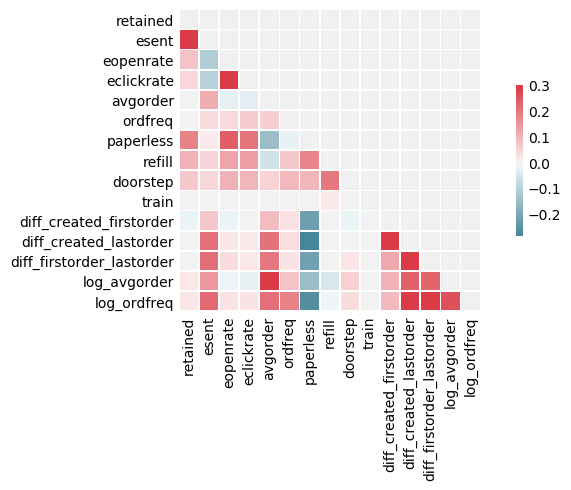

In [33]:
# look at attribute corrlations
cols = keep_cols
train_df = relay_clean[cols]
corr = train_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,4),dpi=100)
# Generate custom diverging colormap
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={'shrink':.5},
    xticklabels=corr.columns,
    yticklabels=corr.columns
)
plt.show()

In [34]:
corr

,retained,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,diff_created_firstorder,diff_created_lastorder,diff_firstorder_lastorder,log_avgorder,log_ordfreq
retained,1.000000,0.717509,0.075023,0.042477,0.004101,0.010744,0.180399,0.103513,0.066517,0.001237,-0.018451,-0.001032,0.009165,0.019206,0.019391
esent,0.717509,1.000000,-0.108275,-0.095311,0.114460,0.036206,0.013800,0.048110,0.042625,-0.002020,0.068500,0.212278,0.217064,0.147774,0.221813
eopenrate,0.075023,-0.108275,1.000000,0.553492,-0.025231,0.039097,0.238592,0.128667,0.104112,0.000652,-0.017952,0.021469,0.035987,-0.015881,0.023881
eclickrate,0.042477,-0.095311,0.553492,1.000000,-0.030405,0.061776,0.204426,0.136177,0.098179,0.001875,0.000341,0.015295,0.018232,-0.025602,0.026001
avgorder,0.004101,0.114460,-0.025231,-0.030405,1.000000,0.060279,-0.149162,-0.059884,0.049083,0.001493,0.087089,0.207144,0.200393,0.809817,0.212719
ordfreq,0.010744,0.036206,0.039097,0.061776,0.060279,1.000000,-0.022794,0.065581,0.090258,0.005865,0.029215,0.035061,0.025753,0.072540,0.180555
paperless,0.180399,0.013800,0.238592,0.204426,-0.149162,-0.022794,1.000000,0.177073,0.098609,0.000076,-0.222208,-0.284345,-0.217167,-0.149069,-0.265753
refill,0.103513,0.048110,0.128667,0.136177,-0.059884,0.065581,0.177073,1.000000,0.196226,0.013805,-0.007739,-0.007707,-0.004918,-0.049000,-0.014872
doorstep,0.066517,0.042625,0.104112,0.098179,0.049083,0.090258,0.098609,0.196226,1.000000,0.002799,-0.017288,0.010014,0.021815,0.053648,0.035646
train,0.001237,-0.002020,0.000652,0.001875,0.001493,0.005865,0.000076,0.013805,0.002799,1.000000,0.005383,0.004021,0.001807,0.002455,-0.003347


In [35]:
independents = ['esent','eopenrate','eclickrate','avgorder','ordfreq','diff_created_firstorder','diff_created_lastorder','diff_firstorder_lastorder']


<Figure size 864x648 with 0 Axes>

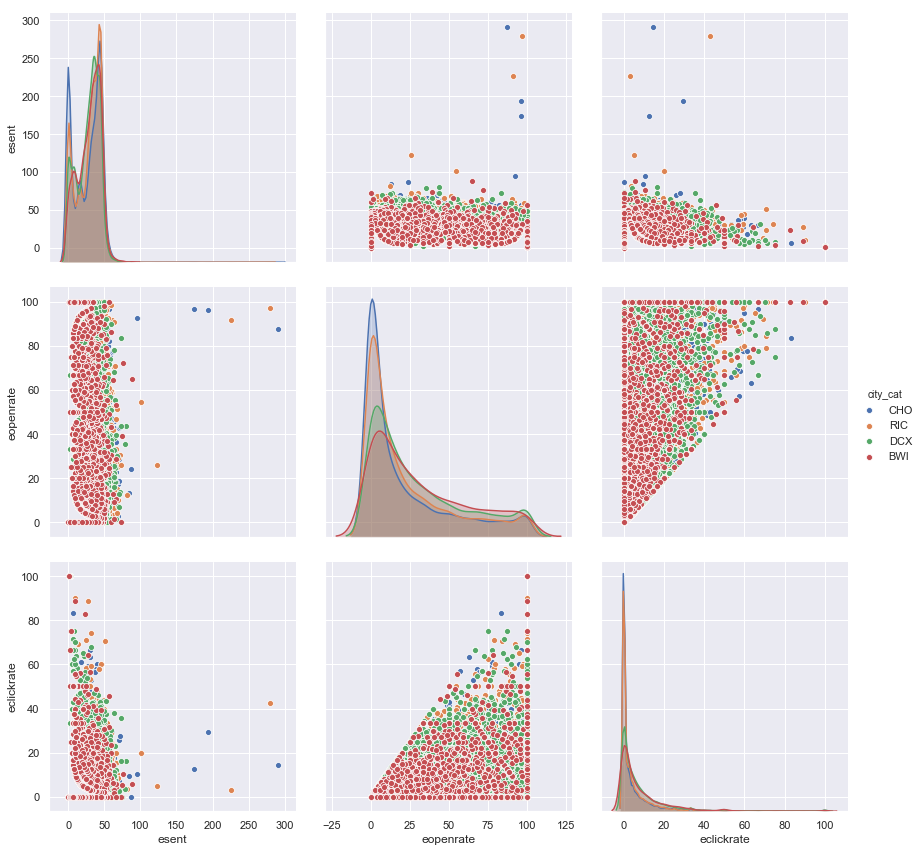

In [36]:
#train_df.columns
sns.set(color_codes=True)
plt.figure(figsize=(12, 9));
df_email = train_df[['esent', 'eopenrate', 'eclickrate','city_cat']]
sns.pairplot(df_email, hue="city_cat", height=4, aspect=1);

plt.show()

<Figure size 864x648 with 0 Axes>

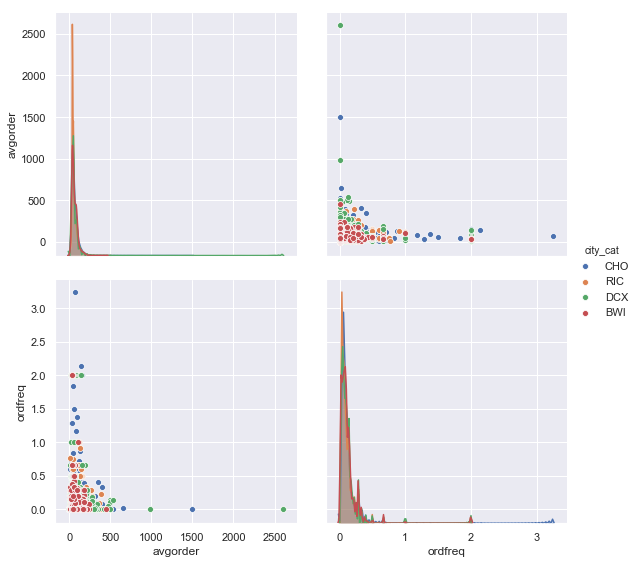

In [37]:
plt.figure(figsize=(12, 9));
df_order = train_df[['avgorder', 'ordfreq', 'city_cat']]
sns.pairplot(df_order, hue="city_cat",height=4, aspect=1);
plt.show()

<Figure size 864x648 with 0 Axes>

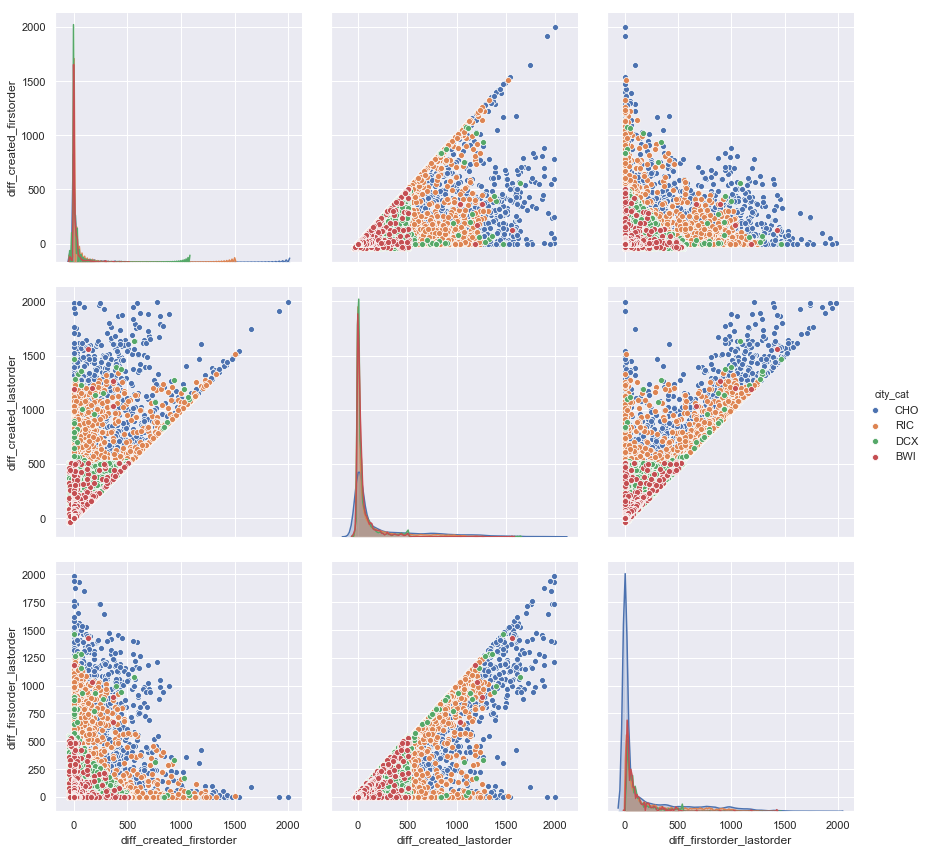

In [38]:
plt.figure(figsize=(12, 9));
df_dates = train_df[['diff_created_firstorder', 'diff_created_lastorder','diff_firstorder_lastorder', 'city_cat']]
sns.pairplot(df_dates, hue="city_cat", height=4, aspect=1);
plt.show()

<Figure size 864x648 with 0 Axes>

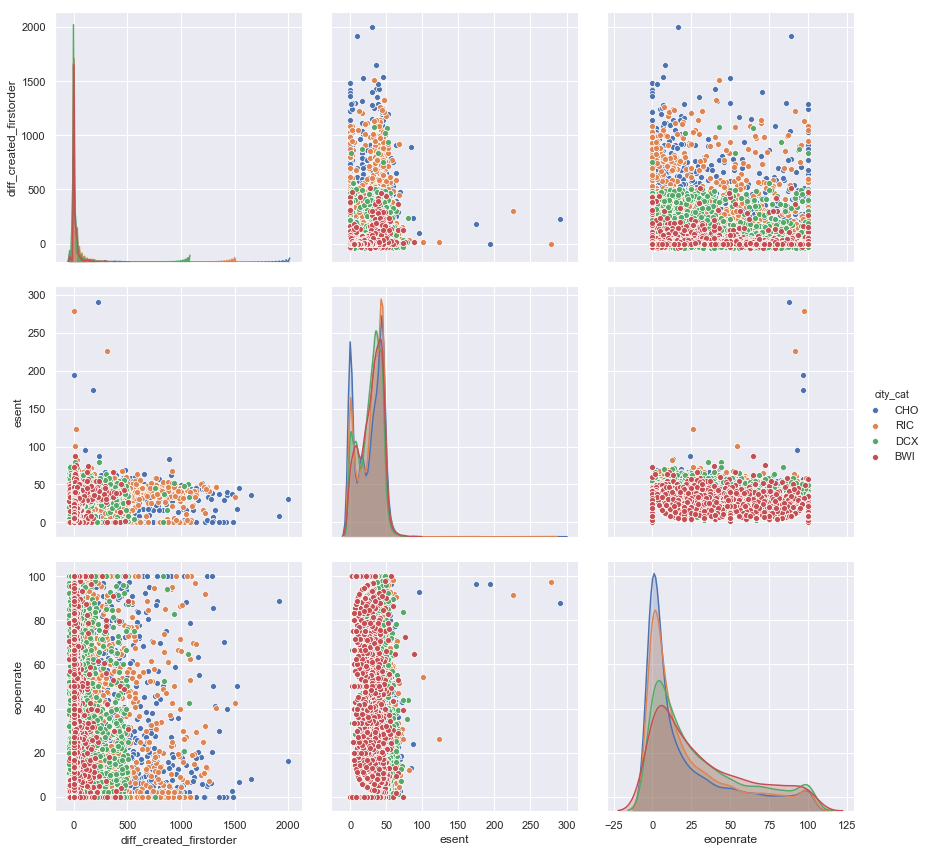

In [111]:
plt.figure(figsize=(12, 9));
df_dates = train_df[['diff_created_firstorder', 'esent','eopenrate', 'city_cat']]
sns.pairplot(df_dates, hue="city_cat", height=4, aspect=1);
plt.show()

### 2.1 SCRUB / CLEAN
Clean and perform initial transformations steps of the data

## 3. MODEL
_________________________________________________________________________________________________
Create models

## 3.1 Model Analysis


In [39]:
train_df.columns

Index(['retained', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq',
       'paperless', 'refill', 'doorstep', 'train', 'diff_created_firstorder',
       'diff_created_lastorder', 'diff_firstorder_lastorder', 'favday_cat',
       'city_cat', 'log_avgorder', 'log_ordfreq'],
      dtype='object')

In [112]:
train_df[['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq','diff_created_firstorder',
       'diff_created_lastorder', 'diff_firstorder_lastorder']].describe()

,esent,eopenrate,eclickrate,avgorder,ordfreq,diff_created_firstorder,diff_created_lastorder,diff_firstorder_lastorder
count,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000,30747.000000
mean,28.137314,25.559618,5.676134,61.848928,0.037769,41.094969,131.677497,90.582528
std,16.751679,29.558790,10.567226,40.956758,0.103998,125.897752,268.840386,223.183471
min,0.000000,0.000000,0.000000,0.000000,0.000000,-39.000000,-39.000000,0.000000
25%,16.000000,2.083333,0.000000,40.020000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,13.207547,0.000000,50.960000,0.000000,1.000000,16.000000,0.000000
75%,42.000000,40.000000,7.142857,74.260000,0.040917,22.000000,107.000000,46.000000
max,291.000000,100.000000,100.000000,2600.140000,3.250000,1998.000000,1998.000000,1985.000000


### 3.1.1 Logistic Regression


In [40]:
import patsy # translate model specifiction into design matrices

relay_m1 = str('retained ~ esent + eopenrate + eclickrate + avgorder + ordfreq + paperless + refill + doorstep + train + diff_created_firstorder + diff_firstorder_lastorder + favday_cat + city_cat')

#relay_m1 = str('retained ~ log_esent + log_eopenrate + log_eclickrate + log_avgorder + log_ordfreq + paperless + refill + doorstep + log_diff_created_firstorder + log_diff_firstorder_lastorder + favday_cat + city_cat')

In [41]:
# ----------------------------------
# fit logistic regression model 
# ----------------------------------
# convert R-like formula into design matrix needed for statsmodels        
y,x = patsy.dmatrices(relay_m1, train_df, return_type = 'dataframe')    

rt_logit_model = sm.Logit(y,x)
# fit the model to the full data set
rt_logit_model_fit = rt_logit_model.fit()
print(rt_logit_model_fit.summary())


Optimization terminated successfully.
         Current function value: 0.167046
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               retained   No. Observations:                30747
Model:                          Logit   Df Residuals:                    30726
Method:                           MLE   Df Model:                           20
Date:                Mon, 24 Feb 2020   Pseudo R-squ.:                  0.6710
Time:                        17:21:50   Log-Likelihood:                -5136.2
converged:                       True   LL-Null:                       -15611.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.9395      0.162    -11.936      0.000      -2.

In [42]:
# predicted probability of reponding 
#relay_train_train['pred_logit_prob'] = 
#p = rt_logit_model_fit.predict(linear = False)
#len(p)

In [43]:
import patsy # translate model specifiction into design matrices
np.random.seed(1234)
train_df['runiform'] = uniform.rvs(loc=0, scale = 1, size = len(train_df))
relay_train_train = train_df[train_df['runiform'] >= 0.33]
relay_train_test = train_df[train_df['runiform'] < 0.33]

In [44]:
# fit the model to the training set
train_model_fit = smf.ols(relay_m1, data = relay_train_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               retained   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     1399.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:21:51   Log-Likelihood:                -1746.9
No. Observations:               20643   AIC:                             3536.
Df Residuals:                   20622   BIC:                             3702.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [45]:
relay_m2 = str('retained ~ esent + eopenrate + eclickrate + avgorder + ordfreq + paperless + refill + doorstep + diff_firstorder_lastorder')
# fit the model to the training set
train_model_fit = smf.ols(relay_m2, data = relay_train_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               retained   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     3088.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:21:51   Log-Likelihood:                -1789.4
No. Observations:               20643   AIC:                             3599.
Df Residuals:                   20633   BIC:                             3678.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [46]:
relay_m3 = str('retained ~ esent + eopenrate + avgorder + ordfreq + paperless + refill + diff_firstorder_lastorder')
# fit the model to the training set
train_model_fit = smf.ols(relay_m3, data = relay_train_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               retained   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     3962.
Date:                Mon, 24 Feb 2020   Prob (F-statistic):               0.00
Time:                        17:21:51   Log-Likelihood:                -1803.5
No. Observations:               20643   AIC:                             3623.
Df Residuals:                   20635   BIC:                             3686.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

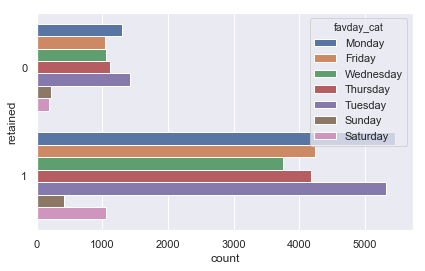

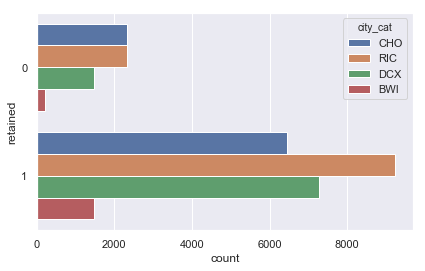

In [47]:
sns.countplot(y="retained", data=train_df,
             hue="favday_cat")
plt.show()

sns.countplot(y="retained", data=train_df,
             hue="city_cat")

plt.show()

In [48]:
# Email attributes
#email = ['esent','eopenrate','eclickrate']
#sns.boxplot(data=train_df[email], orient='h',palette='Set2');
#sns.swarmplot(data=train_df[email], orient='h',palette='Set2');

In [49]:
'''
paperless: 1 if customer subscribed for paperless communication (only online)
refill: 1 if customer subscribed for automatic refill
doorstep: 1 if customer subscribed for doorstep delivery
'''
#subscribe = ['paperless','refill','doorstep']
#sns.boxplot(data=train_df[subscribe], orient='h',palette='Set2');
#sns.swarmplot(data=train_df[subscribe], orient='h',palette='Set2');

'\npaperless: 1 if customer subscribed for paperless communication (only online)\nrefill: 1 if customer subscribed for automatic refill\ndoorstep: 1 if customer subscribed for doorstep delivery\n'

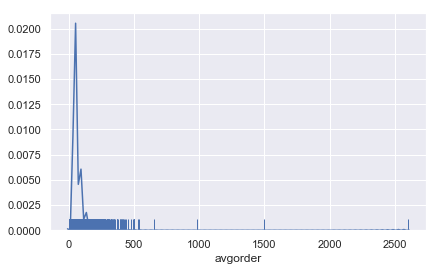

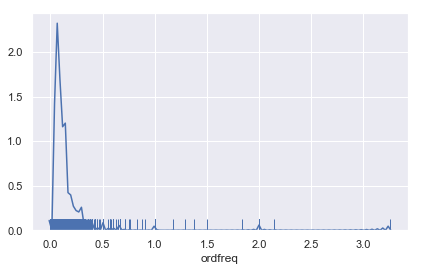

In [50]:
sns.distplot(train_df.avgorder, hist=False, rug=True);
plt.show()
sns.distplot(train_df.ordfreq, hist=False, rug=True);
plt.show()


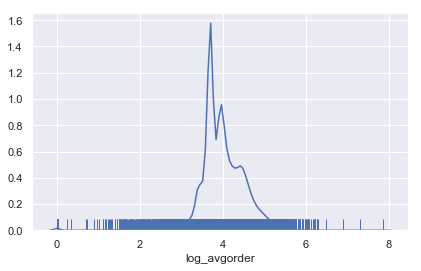

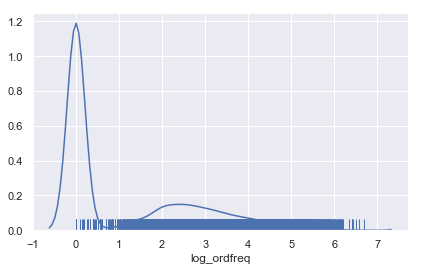

In [51]:
sns.distplot(train_df.log_avgorder, hist=False, rug=True);
plt.show()
sns.distplot(train_df.log_ordfreq, hist=False, rug=True);
plt.show()

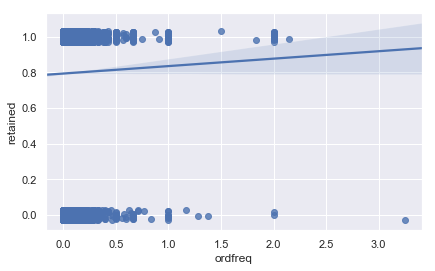

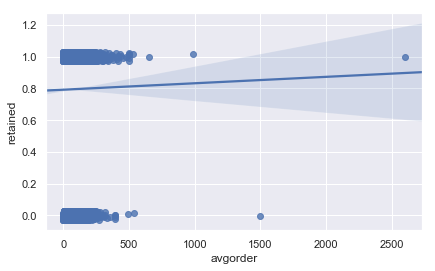

In [52]:
# QUICK SCATTER PLOT TO LOOK AT RELATIONSHIP BETWEEN VARIABLES

sns.set(color_codes=True)

sns.regplot(x="ordfreq", y="retained", data=train_df, y_jitter=0.03)
plt.show()

sns.regplot(x="avgorder", y="retained", data=train_df, y_jitter=0.03)
plt.show()

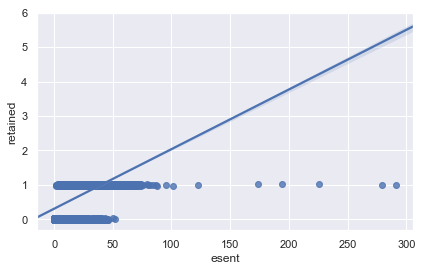

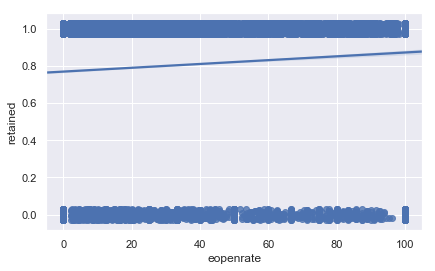

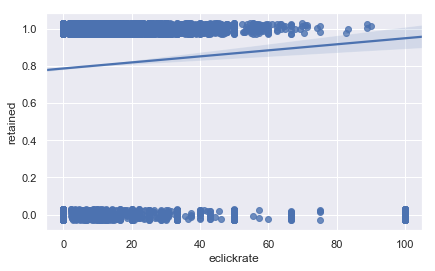

In [53]:

sns.regplot(x="esent", y="retained", data=train_df, y_jitter=0.03)
plt.show()

sns.regplot(x="eopenrate", y="retained", data=train_df, y_jitter=0.03)
plt.show()

sns.regplot(x="eclickrate", y="retained", data=train_df, y_jitter=0.03)
plt.show()

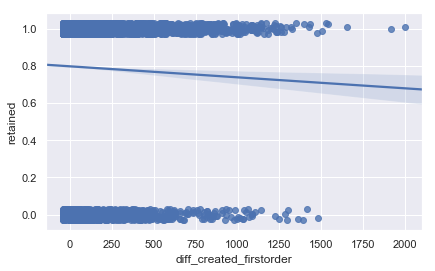

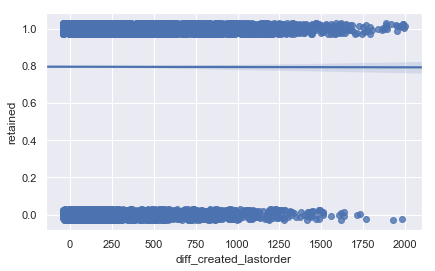

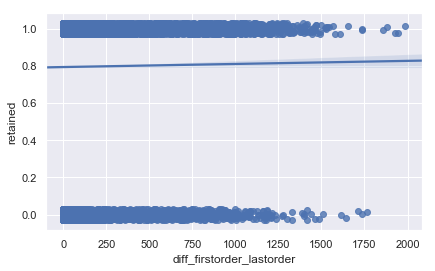

In [54]:
sns.regplot(x="diff_created_firstorder", y="retained", data=train_df, y_jitter=0.03)
plt.show()

sns.regplot(x="diff_created_lastorder", y="retained", data=train_df, y_jitter=0.03)
plt.show()

sns.regplot(x="diff_firstorder_lastorder", y="retained", data=train_df, y_jitter=0.03)
plt.show()

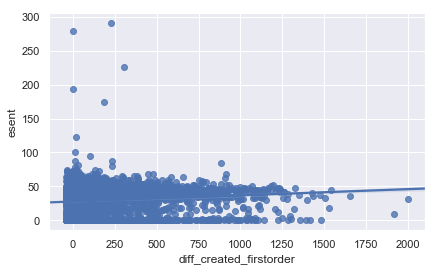

In [110]:
sns.regplot(x="diff_created_firstorder", y="esent", data=train_df, y_jitter=0.03)
plt.show()

In [55]:
train_df.columns

Index(['retained', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq',
       'paperless', 'refill', 'doorstep', 'train', 'diff_created_firstorder',
       'diff_created_lastorder', 'diff_firstorder_lastorder', 'favday_cat',
       'city_cat', 'log_avgorder', 'log_ordfreq', 'runiform'],
      dtype='object')

### 3.2 Model Exploration


In [56]:
modelsPerformance = {'ModelName':[], 'TestAccuracyScore':[],'PredictAccuracyScore':[] ,'FitTime':[], 'ScoreTime':[], 'PredictTime':[]}

In [57]:
# Confusion matrix 
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{imageDir}/{model_name}_cm.png', dpi=150)
    plt.show()

In [58]:
# function used for clocking processing time to build/run models
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start

In [59]:
'''
# Takes in training data and a model, and plots a bar graph of the model's feature importances
'''
def plot_feature_importances(features, model, model_name, logger, max_num_features=10):
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = features
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    logger.info(feature_importances)
    
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');
    plt.show()

In [60]:
train_df.columns

Index(['retained', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq',
       'paperless', 'refill', 'doorstep', 'train', 'diff_created_firstorder',
       'diff_created_lastorder', 'diff_firstorder_lastorder', 'favday_cat',
       'city_cat', 'log_avgorder', 'log_ordfreq', 'runiform'],
      dtype='object')

In [61]:
def getNaNIndexes(df,att):
    n = np.where(df[att].isnull()==True)

In [62]:
logger.info(f'{getNaNIndexes(train_df,"diff_created_lastorder")}')

None


In [63]:
# validation splits
X = train_df.drop(columns=['retained','runiform','favday_cat','city_cat','avgorder','ordfreq','train'])
y = train_df['retained']
logger.info(f'y shape: {y.shape}')
logger.info(f'X shape: {X.shape}')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

logger.info(f'X_train shape: {X_train.shape}')
logger.info(f'X_test shape: {X_test.shape}')
logger.info(f'y_train shape: {y_train.shape}')
logger.info(f'y_test shape: {y_test.shape}')


y shape: (30747,)
X shape: (30747, 11)
X_train shape: (24597, 11)
X_test shape: (6150, 11)
y_train shape: (24597,)
y_test shape: (6150,)


In [1]:
nan_rows = train_df[train_df.isnull().T.any().T]
nan_rows

NameError: name 'train_df' is not defined

In [65]:
X_train.columns

Index(['esent', 'eopenrate', 'eclickrate', 'paperless', 'refill', 'doorstep',
       'diff_created_firstorder', 'diff_created_lastorder',
       'diff_firstorder_lastorder', 'log_avgorder', 'log_ordfreq'],
      dtype='object')

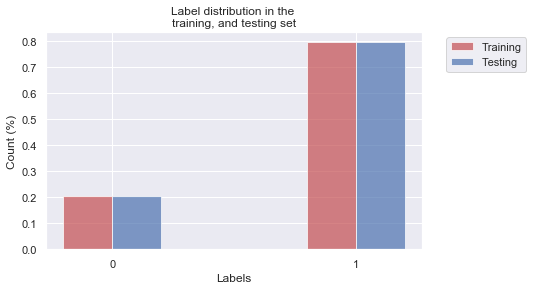

In [66]:
# number of label classes
n_classes = 2

# look for imbalance in the sample observations for the class
training_counts = [None] * n_classes
testing_counts = [None] * n_classes

for i in range(n_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)
    

# plot histogram of the data
train_bar = plt.bar(np.arange(n_classes)-0.1, training_counts, align='center', color = 'r', alpha=0.70, width = 0.2, label='Training')
test_bar = plt.bar(np.arange(n_classes)+0.1, testing_counts, align='center', color = 'b', alpha=0.70, width = 0.2, label = 'Testing')


plt.xlabel('Labels')
plt.xticks((0,1))
plt.ylabel('Count (%)')
plt.title('Label distribution in the \ntraining, and testing set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar], loc=2)
plt.grid(True)
plt.savefig(f'{imageDir}/dt_explore_label_distribution.png', dpi=300)
plt.show()

## Test Upsampling

In [132]:
from sklearn.utils import resample
not_retained=train_df[train_df.retained==0]
retained=train_df[train_df.retained==1]

logger.info(f'Original data split, Not Retained: {not_retained.shape}')
logger.info(f'Original data split, Is Retained: {retained.shape}')

# upsample minority
notretained_upsampled = resample(not_retained,
                          replace=True, # sample with replacement
                          n_samples=len(retained), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([retained, notretained_upsampled])

# check new class counts
upsampled.retained.value_counts()
logger.info(f'upsampled retained count:\n {upsampled.retained.value_counts()}')
logger.info(f'upsampled shape: {upsampled.shape}')

Original data split, Not Retained: (6314, 18)
Original data split, Is Retained: (24433, 18)
upsampled retained count:
 1    24433
0    24433
Name: retained, dtype: int64
upsampled shape: (48866, 18)


In [133]:
# validation splits
X = upsampled.drop(columns=['retained','runiform','favday_cat','city_cat','avgorder','ordfreq','train'])
y = upsampled['retained']
logger.info(f'y shape: {y.shape}')
logger.info(f'X shape: {X.shape}')

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

logger.info(f'X_train shape: {X_train.shape}')
logger.info(f'X_test shape: {X_test.shape}')
logger.info(f'y_train shape: {y_train.shape}')
logger.info(f'y_test shape: {y_test.shape}')


y shape: (48866,)
X shape: (48866, 11)
X_train shape: (39092, 11)
X_test shape: (9774, 11)
y_train shape: (39092,)
y_test shape: (9774,)


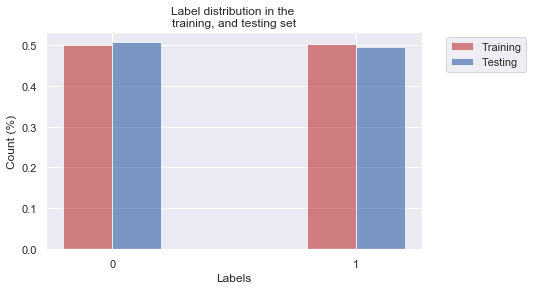

In [146]:
# number of label classes
n_classes = 2

# look for imbalance in the sample observations for the class
training_counts = [None] * n_classes
testing_counts = [None] * n_classes

for i in range(n_classes):
    training_counts[i] = len(y_train[y_train == i])/len(y_train)
    testing_counts[i] = len(y_test[y_test == i])/len(y_test)
    

# plot histogram of the data
train_bar = plt.bar(np.arange(n_classes)-0.1, training_counts, align='center', color = 'r', alpha=0.70, width = 0.2, label='Training')
test_bar = plt.bar(np.arange(n_classes)+0.1, testing_counts, align='center', color = 'b', alpha=0.70, width = 0.2, label = 'Testing')


plt.xlabel('Labels')
plt.xticks((0,1))
plt.ylabel('Count (%)')
plt.title('Label distribution in the \ntraining, and testing set')
plt.legend(bbox_to_anchor=(1.05, 1), handles=[train_bar, test_bar], loc=2)
plt.grid(True)
plt.savefig(f'{imageDir}/dt_explore_label_distribution.png', dpi=300)
plt.show()

### 3.3 Model Build - Decision Tree Classifier

In [67]:
def build_tree(random_state,max_depth,min_samples_split):
    t = tree.DecisionTreeClassifier(
        criterion="gini", 
        splitter="best", 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=1, 
        min_weight_fraction_leaf=0.0, 
        max_features=None, 
        random_state=None, 
        max_leaf_nodes=None, 
        min_impurity_decrease=0.0, 
        min_impurity_split=None, 
        class_weight=None, 
        presort=False)
    
    return t

In [134]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
cv=3
scoring = ['precision_macro', 'recall_macro']
max_depth = None
min_samples_split = 2
with_zip = 'zip_true'
model_name = f'DecisionTree_{max_depth}_{min_samples_split}_{with_zip}'

# build the tree
dtc = build_tree(random_state=42,max_depth=max_depth,min_samples_split=min_samples_split)
t = 0.0
with elapsed_timer() as elapsed:
    # fit the forest to the training data
    #dtc_fit = dtc.fit(X_train, y_train)
    dtc_cv_scores = cross_validate(dtc, X_train, y_train, scoring=scoring, cv=cv, 
                                return_train_score=True, return_estimator=True) 
    t = elapsed()
    logger.info(f'DecisionTreeClassifier Model Build Time: [{t}]')

modelsPerformance['ModelName'].append(model_name)
modelsPerformance['FitTime'].append(t)

# output model results
logger.info(f'Scorer Names: {sorted(dtc_cv_scores.keys())}')
logger.info(f'Fit Time:               {dtc_cv_scores["fit_time"]}')
logger.info(f'Score Time:             {dtc_cv_scores["score_time"]}')
logger.info(f'Test Recall Scores:     {dtc_cv_scores["test_recall_macro"]}')
logger.info(f'Test Precision Scores:  {dtc_cv_scores["test_precision_macro"]}')
logger.info(f'Train Recall Scores:    {dtc_cv_scores["train_recall_macro"]}')
logger.info(f'Train Precision Scores: {dtc_cv_scores["train_precision_macro"]}')                         


DecisionTreeClassifier Model Build Time: [0.4746537000000899]
Scorer Names: ['estimator', 'fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'train_precision_macro', 'train_recall_macro']
Fit Time:               [0.11073136 0.10571694 0.11469293]
Score Time:             [0.01493073 0.01595664 0.01296496]
Test Recall Scores:     [0.96346693 0.95992957 0.96376313]
Test Precision Scores:  [0.96428953 0.96071066 0.96445918]
Train Recall Scores:    [0.99697663 0.99686234 0.99670863]
Train Precision Scores: [0.99697441 0.99686104 0.99670694]


In [135]:
dtc_cv_scores["test_precision_macro"]

array([0.96428953, 0.96071066, 0.96445918])

In [136]:
bestFit = dtc_cv_scores["test_precision_macro"].argmax()
dtc_cv_est = dtc_cv_scores['estimator'][bestFit]

modelsPerformance['TestAccuracyScore'].append(dtc_cv_scores["test_precision_macro"][bestFit])
logger.info(f'TestAccuracyScore BestFit: {dtc_cv_scores["test_precision_macro"][bestFit]}')

TestAccuracyScore BestFit: 0.9644591839932106


In [137]:
#%%time
# predictions of test set split from training set
bestFit = dtc_cv_scores["test_precision_macro"].argmax()
dtc_cv_est = dtc_cv_scores['estimator'][bestFit]
t = 0.0
with elapsed_timer() as elapsed:
    dtc_cv_pred = dtc_cv_est.predict(X_test)
    t = elapsed()
    logger.info(f'DecisionTreeClassifier Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

DecisionTreeClassifier Predict Time: [0.0038067999994382262]


In [138]:
%%time
logger.info(f'y_test size: {y_test.size} dtc_pred size: {dtc_cv_pred.size}')

d = {'Label':y_test, 'Prediction':dtc_cv_pred}
treeCVPredictionsDf = pd.DataFrame(data=d)
logger.info(f'Decision Tree Predictions DF Shape: {treeCVPredictionsDf.shape}\n Head:\n{treeCVPredictionsDf.head()}')

# which test observations were miss classified
missClassified_DTCV = treeCVPredictionsDf[(treeCVPredictionsDf['Label'] != treeCVPredictionsDf['Prediction'])]

logger.info(f'Miss Classified DF Shape: {missClassified_DTCV.shape}')
logger.info(f'Miss Classified Percent: {missClassified_DTCV.shape[0]/y_test.size}')
logger.info(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != dtc_cv_pred).sum()}]')

y_test size: 9774 dtc_pred size: 9774
Decision Tree Predictions DF Shape: (9774, 2)
 Head:
       Label  Prediction
14934      1           1
13441      0           0
10504      0           0
12782      1           1
227        0           0
Miss Classified DF Shape: (382, 2)
Miss Classified Percent: 0.03908328217720483
Total Number of points: [9774]  Mislabeled Points: [382]


Wall time: 11.9 ms


Total Number of points: [9774]  Mislabeled Points: [382]
Percent Mislabeled: [0.03908328217720483]
Percent Accurately Labeled: [0.9609167178227952]


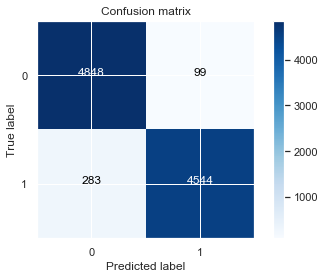


              precision    recall  f1-score   support

      Class0       0.94      0.98      0.96      4947
      Class1       0.98      0.94      0.96      4827

   micro avg       0.96      0.96      0.96      9774
   macro avg       0.96      0.96      0.96      9774
weighted avg       0.96      0.96      0.96      9774



In [139]:
misLabeled = (y_test != dtc_cv_pred).sum()/X_test.shape[0]
dtcCvAccuractelyLabeled = 1-misLabeled

logger.info(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != dtc_cv_pred).sum()}]')
logger.info(f'Percent Mislabeled: [{((y_test != dtc_cv_pred).sum()/X_test.shape[0])}]')
logger.info(f'Percent Accurately Labeled: [{dtcCvAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(dtcCvAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,dtc_cv_pred, labels=[0,1])
plot_confusion_matrix(cm,classes=[0,1])

#print classification report table
n_classes=2
targetNames = ["Class{}".format(i) for i in range(n_classes)]
print(f'\n{classification_report(y_test, dtc_cv_pred, target_names=targetNames)}')

In [122]:
features = list(X_train.columns)

                      feature  importance
0                       esent    0.764182
9                log_avgorder    0.056722
1                   eopenrate    0.053001
2                  eclickrate    0.034408
7      diff_created_lastorder    0.032540
6     diff_created_firstorder    0.021994
3                   paperless    0.012675
10                log_ordfreq    0.008497
8   diff_firstorder_lastorder    0.006982
4                      refill    0.005451


<Figure size 432x288 with 0 Axes>

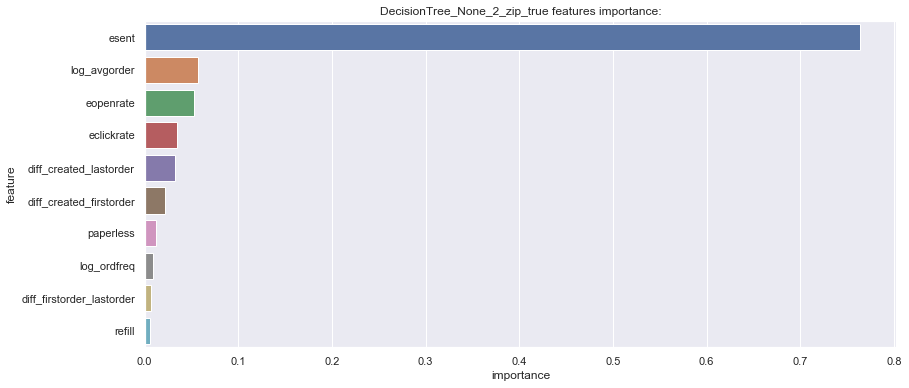

In [140]:
# Decision Tree - Feature importance
plt.savefig(f'{imageDir}/{model_name}_fimp.png', dpi=300)
plot_feature_importances(features, dtc_cv_est, model_name, logger)
#dtc.feature_importances_

### 3.4 Model Build - Random Forest Classifier
Python Package: scikit-learn v0.21.3 [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).<br>

* n_estimators: 100
* max_depth: None (default)
* min_samples_plit=2

In [76]:
rf_base = RandomForestClassifier(n_estimators=100,             # The number of trees in the forest.
                                 criterion="gini",             # The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
                                 max_depth=None,               # The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
                                 min_samples_split=2,          # The minimum number of samples required to split an internal node
                                 min_samples_leaf=1,           # The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches
                                 min_weight_fraction_leaf=0.0, # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
                                 max_features="auto",          # The number of features to consider when looking for the best split: If “auto”, then max_features=sqrt(n_features).
                                 max_leaf_nodes=None,          # Grow trees with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                                 min_impurity_decrease=0.0,    # A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                                 min_impurity_split=None,      # Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
                                 bootstrap=True,               # Whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree
                                 oob_score=False,              # Whether to use out-of-bag samples to estimate the generalization accuracy.
                                 n_jobs=None,                  # The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors
                                 random_state=None,            # if int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random
                                 verbose=1,                    # Controls the verbosity when fitting and predicting.
                                 warm_start=False,             # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                                 class_weight=None             # Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. For multi-output problems, a list of dicts can be provided in the same order as the columns of y.
                                )

In [141]:
cv=3
scoring = ['precision_macro', 'recall_macro']
max_depth = None
min_samples_split = 2
with_zip = 'zip_true'
model_name = f'RandomForest_{max_depth}_{min_samples_split}_{with_zip}'

# build the tree
rf_base
t = 0.0
with elapsed_timer() as elapsed:
    # fit the forest to the training data
    #dtc_fit = dtc.fit(X_train, y_train)
    rf_cv_scores = cross_validate(rf_base, X_train, y_train, scoring=scoring, cv=cv, 
                                return_train_score=True, return_estimator=True) 
    t = elapsed()
    logger.info(f'RandomForest Model Build Time: [{t}]')

modelsPerformance['ModelName'].append(model_name)
modelsPerformance['FitTime'].append(t)

# output model results
logger.info(f'Scorer Names: {sorted(rf_cv_scores.keys())}')
logger.info(f'Fit Time:               {rf_cv_scores["fit_time"]}')
logger.info(f'Score Time:             {rf_cv_scores["score_time"]}')
logger.info(f'Test Recall Scores:     {rf_cv_scores["test_recall_macro"]}')
logger.info(f'Test Precision Scores:  {rf_cv_scores["test_precision_macro"]}')
logger.info(f'Train Recall Scores:    {rf_cv_scores["train_recall_macro"]}')
logger.info(f'Train Precision Scores: {rf_cv_scores["train_precision_macro"]}')                         


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [142]:
bestFit = rf_cv_scores["test_precision_macro"].argmax()
rf_cv_est = rf_cv_scores['estimator'][bestFit]

modelsPerformance['TestAccuracyScore'].append(rf_cv_scores["test_precision_macro"][bestFit])
logger.info(f'TestAccuracyScore BestFit: {rf_cv_scores["test_precision_macro"][bestFit]}')

TestAccuracyScore BestFit: 0.9758047191893264


In [143]:
#%%time
# predictions of test set split from training set
bestFit = rf_cv_scores["test_precision_macro"].argmax()
rf_cv_est = rf_cv_scores['estimator'][bestFit]
t = 0.0
with elapsed_timer() as elapsed:
    rf_cv_pred = rf_cv_est.predict(X_test)
    t = elapsed()
    logger.info(f'RandomForest Predict Time: [{t}]')

modelsPerformance['PredictTime'].append(t)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
RandomForest Predict Time: [0.22719139999935578]


In [144]:
%%time
logger.info(f'y_test size: {y_test.size} rf_cv_pred size: {rf_cv_pred.size}')

d = {'Label':y_test, 'Prediction':rf_cv_pred}
treeCVPredictionsDf = pd.DataFrame(data=d)
logger.info(f'Random Forest Predictions DF Shape: {treeCVPredictionsDf.shape}\n Head:\n{treeCVPredictionsDf.head()}')

# which test observations were miss classified
missClassified_RFCV = treeCVPredictionsDf[(treeCVPredictionsDf['Label'] != treeCVPredictionsDf['Prediction'])]

logger.info(f'Miss Classified DF Shape: {missClassified_RFCV.shape}')
logger.info(f'Miss Classified Percent: {missClassified_RFCV.shape[0]/y_test.size}')
logger.info(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != rf_cv_pred).sum()}]')

y_test size: 9774 rf_cv_pred size: 9774
Random Forest Predictions DF Shape: (9774, 2)
 Head:
       Label  Prediction
14934      1           1
13441      0           0
10504      0           0
12782      1           1
227        0           0
Miss Classified DF Shape: (280, 2)
Miss Classified Percent: 0.02864743196234909
Total Number of points: [9774]  Mislabeled Points: [280]


Wall time: 10 ms


Total Number of points: [9774]  Mislabeled Points: [280]
Percent Mislabeled: [0.02864743196234909]
Percent Accurately Labeled: [0.9713525680376509]


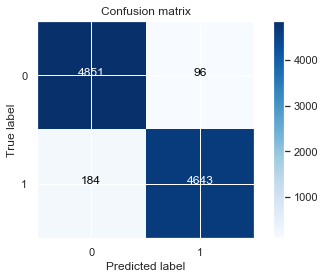


              precision    recall  f1-score   support

      Class0       0.96      0.98      0.97      4947
      Class1       0.98      0.96      0.97      4827

   micro avg       0.97      0.97      0.97      9774
   macro avg       0.97      0.97      0.97      9774
weighted avg       0.97      0.97      0.97      9774



In [145]:
misLabeled = (y_test != rf_cv_pred).sum()/X_test.shape[0]
rfcCvAccuractelyLabeled = 1-misLabeled

logger.info(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != rf_cv_pred).sum()}]')
logger.info(f'Percent Mislabeled: [{((y_test != rf_cv_pred).sum()/X_test.shape[0])}]')
logger.info(f'Percent Accurately Labeled: [{rfcCvAccuractelyLabeled}]')
modelsPerformance['PredictAccuracyScore'].append(rfcCvAccuractelyLabeled)
    
# confusion matrix evaluation
cm = confusion_matrix(y_test,rf_cv_pred, labels=[0,1])
plot_confusion_matrix(cm,classes=[0,1])

#print classification report table
n_classes=2
targetNames = ["Class{}".format(i) for i in range(n_classes)]
print(f'\n{classification_report(y_test, rf_cv_pred, target_names=targetNames)}')

                      feature  importance
0                       esent    0.574000
1                   eopenrate    0.154961
2                  eclickrate    0.091673
9                log_avgorder    0.065342
7      diff_created_lastorder    0.032458
6     diff_created_firstorder    0.025534
10                log_ordfreq    0.014898
8   diff_firstorder_lastorder    0.014566
3                   paperless    0.013205
4                      refill    0.008963


<Figure size 432x288 with 0 Axes>

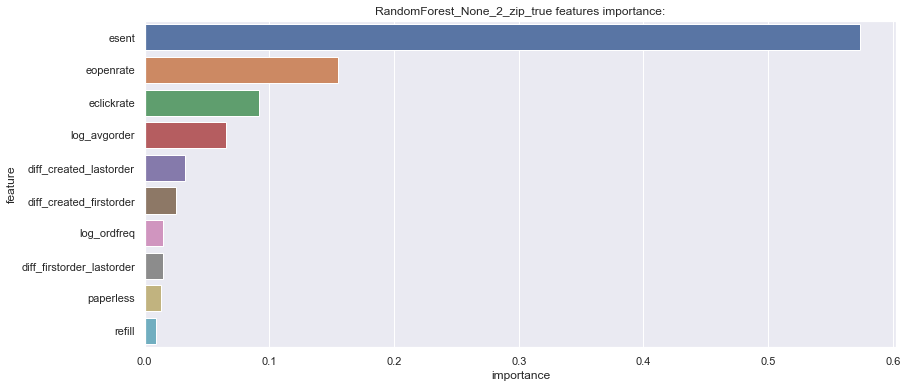

In [129]:
# Decision Tree - Feature importance
plt.savefig(f'{imageDir}/{model_name}_fimp.png', dpi=300)
plot_feature_importances(features, rf_cv_est, model_name, logger)


In [83]:
rf_cv_est.feature_importances_

array([0.66592143, 0.11618757, 0.05581475, 0.01492044, 0.00595889,
       0.00319094, 0.02332989, 0.03110598, 0.01390306, 0.05689878,
       0.01276826])

In [84]:
# test log probability output
t = 0.0
with elapsed_timer() as elapsed:
    rf_cv_pred_proba = rf_cv_est.predict_proba(X_test)
    t = elapsed()
    logger.info(f'RandomForest Probability Predict Time: [{t}]')

#modelsPerformance['PredictTime'].append(t)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
RandomForest Probability Predict Time: [0.1369853000000063]


In [85]:
#rf_cv_pred_proba[:10]
pretain = []
p_class1 = []
p_class0 = []
for pred in rf_cv_pred_proba:
    p_class1.append(pred[1])
    p_class0.append(pred[0])
    #print(pred)
    if pred[0] >= .5:
        pretain.append(0)
    else:
        pretain.append(1)
    #break
logger.info(f'{len(pretain)}')

6150


In [86]:
pred_df = pd.DataFrame()
pred_df['retained'] = y_test
pred_df['pretain'] = pretain

pred_df.head()

,retained,pretain
19795,1,1
21000,1,1
10493,1,1
10919,1,1
7363,0,0


In [87]:
true_pred = []
for i, row in pred_df.iterrows():
    if row['retained'] == row['pretain']:
        true_pred.append(1)
    else:
        true_pred.append(0)
pred_df['true_pred'] = true_pred
pred_df.head()

,retained,pretain,true_pred
19795,1,1,1
21000,1,1,1
10493,1,1,1
10919,1,1,1
7363,0,0,1


In [88]:
X_test.shape[0]
logger.info(f'Predicted Hit Rate: {pred_df["true_pred"].sum()/X_test.shape[0]}')

Predicted Hit Rate: 0.9590243902439024


In [89]:
rf_cv_pred_proba

array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       ...,
       [0.  , 1.  ],
       [0.34, 0.66],
       [0.06, 0.94]])

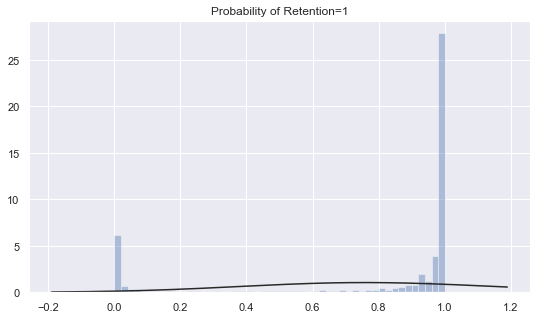

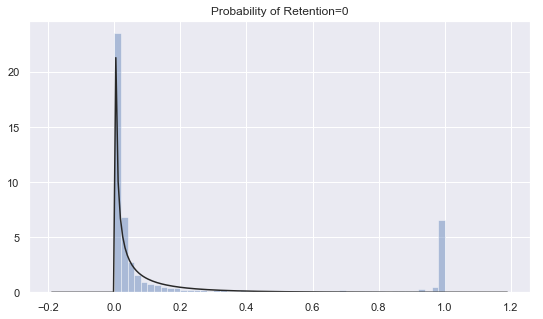

In [90]:
plt.figure(figsize=(8, 5));
sns.distplot(p_class1, kde=False, fit=stats.gamma);
plt.title('Probability of Retention=1');
plt.show()

plt.figure(figsize=(8, 5));
sns.distplot(p_class0, kde=False, fit=stats.gamma);
plt.title('Probability of Retention=0');
plt.show()

## 3.4 Model Build - LogisticRegressionCV
LogisticRegressionCV(Cs=10, fit_intercept=True, cv=None, dual=False, penalty='l2', scoring=None, solver='lbfgs', tol=0.0001, max_iter=100, class_weight=None, n_jobs=None, verbose=0, refit=True, intercept_scaling=1.0, multi_class='auto', random_state=None, l1_ratios=None)

In [91]:
from sklearn.linear_model import LogisticRegressionCV
scoring = ['precision_macro', 'recall_macro']
lrcv = LogisticRegressionCV(Cs=10, 
                            fit_intercept=True, 
                            cv=5, 
                            dual=False, 
                            penalty='l2', 
                            scoring=None, 
                            solver='lbfgs', 
                            tol=0.0001, 
                            max_iter=100, 
                            class_weight=None, 
                            n_jobs=None, 
                            verbose=0, 
                            refit=True, 
                            intercept_scaling=1.0, 
                            multi_class='auto', 
                            random_state=42, 
                            #l1_ratios=None
                           )

In [92]:
lrcv_fit = lrcv.fit(X_train, y_train)


In [93]:
lrcv_pred = lrcv.predict(X_test)

In [94]:
lrcv_pred_prob = lrcv.predict_proba(X_test)

In [95]:
lrcv_fit.scores_

{1: array([[0.94512195, 0.9445122 , 0.94471545, 0.94410569, 0.94512195,
         0.94593496, 0.94593496, 0.94593496, 0.94593496, 0.94593496],
        [0.94065041, 0.94044715, 0.94329268, 0.94410569, 0.94369919,
         0.94390244, 0.94329268, 0.94329268, 0.94329268, 0.94329268],
        [0.94104493, 0.94104493, 0.93962187, 0.94145151, 0.94267127,
         0.9418581 , 0.94226469, 0.94124822, 0.94124822, 0.94124822],
        [0.9357593 , 0.93677577, 0.93636918, 0.93718235, 0.93860541,
         0.93819882, 0.93819882, 0.93819882, 0.93819882, 0.93819882],
        [0.93392966, 0.93596259, 0.93697906, 0.93616589, 0.93636918,
         0.93596259, 0.93596259, 0.93596259, 0.93596259, 0.93596259]])}

In [96]:
# R^2 (coefficient of determination) regression score function.
from sklearn.metrics import r2_score

logger.info(f'R^2 Coefficient of determination: {r2_score(y_test, lrcv_pred)}')

R^2 Coefficient of determination: 0.6564340104346233


In [97]:
lrcv_pred_df = pd.DataFrame()
lrcv_pred_df['retained'] = y_test
lrcv_pred_df['pretain'] = lrcv_pred

lrcv_pred_df.head()

,retained,pretain
19795,1,1
21000,1,1
10493,1,1
10919,1,1
7363,0,0


In [98]:
lrcv_true_pred = []
lrcv_true_class0 = []
lrcv_true_class1 = []
for i, row1 in lrcv_pred_df.iterrows():
    if row1['retained'] == row1['pretain']:
        lrcv_true_pred.append(1)
        
        if row1['retained'] == 1:
            lrcv_true_class1.append(1)
        else:
            lrcv_true_class0.append(1)
    else:
        lrcv_true_pred.append(0)
        
        if row1['retained'] == 1 and row1['pretain'] == 0:
            lrcv_true_class1.append(0)
        elif row1['retained'] == 0 and row1['pretain'] == 1:
            lrcv_true_class0.append(0)
            
lrcv_pred_df['true_pred'] = lrcv_true_pred
#lrcv_pred_df['true_class1'] = lrcv_true_class1
#lrcv_pred_df['true_class0'] = lrcv_true_class0

lrcv_pred_df.head()

X_test.shape[0]
logger.info(f'LogisticRegressionCV Predicted Hit Rate: {lrcv_pred_df["true_pred"].sum()/X_test.shape[0]}')
#logger.info(f'LogisticRegressionCV Predicted True Class 1: {lrcv_pred_df["true_class1"].sum()/X_test.shape[0]}')
#logger.info(f'LogisticRegressionCV Predicted True Class 0: {lrcv_pred_df["true_class0"].sum()/X_test.shape[0]}')            

LogisticRegressionCV Predicted Hit Rate: 0.9440650406504065


In [99]:
lrcv_pred_df.head()

,retained,pretain,true_pred
19795,1,1,1
21000,1,1,1
10493,1,1,1
10919,1,1,1
7363,0,0,1


In [100]:
logger.info(f'lenght true class 0: {len(lrcv_true_class0)}')
logger.info(f'sum true class 0: {np.array(lrcv_true_class0).sum()}')
logger.info(f'percent accuracy - true class 0: {np.array(lrcv_true_class0).sum()/len(lrcv_true_class0)}')

logger.info(f'lenght true class 1: {len(lrcv_true_class1)}')
logger.info(f'sum true class 1: {np.array(lrcv_true_class1).sum()}')
logger.info(f'percent accuracy - true class 1: {np.array(lrcv_true_class1).sum()/len(lrcv_true_class1)}')

lenght true class 0: 1259
sum true class 0: 1070
percent accuracy - true class 0: 0.8498808578236696
lenght true class 1: 4891
sum true class 1: 4736
percent accuracy - true class 1: 0.9683091392353302


In [101]:
lrcv_fit.intercept_[0]

-1.8223254730325862

In [102]:
coefs = []
coef_values = []
coefs.append('intercept')
coef_values.append(lrcv_fit.intercept_[0])

coefs = coefs + list(X_train.columns)
coef_values = coef_values + list(lrcv_fit.coef_[0])
coef_df = pd.DataFrame()
coef_df['coef'] =  coefs
coef_df['coef_value'] = coef_values

coef_df

,coef,coef_value
0,intercept,-1.822325
1,esent,0.211279
2,eopenrate,0.007011
3,eclickrate,0.010719
4,paperless,0.190017
5,refill,0.743016
6,doorstep,0.858336
7,diff_created_firstorder,-0.000297
8,diff_created_lastorder,-0.001047
9,diff_firstorder_lastorder,-0.000750


In [103]:
lrcv.densify()

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='auto', n_jobs=None, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [104]:
lrcv.decision_function(X_train)

array([6.82201656, 6.07565633, 4.3355294 , ..., 6.93635732, 5.32993158,
       0.34127176])

In [105]:
lrcv_fit.score(X_train,y_train)

0.9411716876041794

### 3.5 Model Results

#### Model Validation
Perform model validations

### iNterpret
Interpret the model results, make knowledge based recommendations

In [106]:
# perform interpretation steps

# Report Generation
Execute the below cell to create an HTML report

In [107]:
# for report auto generation
# testing markup report generation
from nbconvert import HTMLExporter
import codecs
import os
import datetime

stamp = datetime.date.today().strftime("%m-%d-%Y")
exporter = HTMLExporter(template_file='report.tpl')
output, resources = exporter.from_filename(notebook_file_name)
new_fnw = report_file_name
codecs.open(new_fnw, 'w',encoding='utf-8').write(output)

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'relay_cust_churn'